# CL for multi-annotator data [cifar10h] [benchmarking]
- This notebook uses the results from the model_train_pred notebook to evaluate model performance. Also evaluates general multi-annotator dataset health

In [44]:
%load_ext autoreload
%autoreload 2

import cleanlab
from cleanlab.rank import get_label_quality_scores, get_label_quality_ensemble_scores
from cleanlab.internal.label_quality_utils import get_normalized_entropy

import sys
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, log_loss
from matplotlib import pyplot as plt

sys.path.insert(0, "../")
from utils.eval_metrics import lift_at_k
from utils.active_learning_scores import least_confidence
# experimental version of label quality ensemble scores with additional weighting schemes
from utils.label_quality_ensemble_scores_experimental import get_label_quality_ensemble_scores_experimental

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
!pwd

/Users/uly/Documents/Cleanlab/multiannotator_benchmark


### Load/Analyze Cifar10h Data

In [46]:
df = pd.read_csv('./data/cifar10h/cifar10h-raw.csv')
df = df[df.cifar10_test_test_idx != -99999] # dropping all attention check trials
df.head()

,annotator_id,trial_index,is_attn_check,true_category,chosen_category,true_label,chosen_label,correct_guess,cifar10_test_test_idx,image_filename,subcategory,reaction_time,time_elapsed
0,0,0,0,ship,ship,8,8,1,6798,cabin_cruiser_s_000814.png,cabin_cruiser,1342,1342
1,0,1,0,deer,horse,4,7,0,1118,alces_alces_s_000236.png,alces_alces,4305,6244
2,0,2,0,horse,horse,7,7,1,5965,stud_mare_s_001236.png,stud_mare,2811,9274
3,0,3,0,truck,automobile,9,1,0,6167,delivery_van_s_000100.png,delivery_van,1136,10610
4,0,4,0,deer,bird,4,2,0,373,elk_s_000359.png,elk,4410,15994


In [47]:
df.describe()

,annotator_id,trial_index,is_attn_check,true_label,chosen_label,correct_guess,cifar10_test_test_idx,reaction_time,time_elapsed
count,514200.000000,514200.000000,514200.0,514200.000000,514200.000000,514200.000000,514200.000000,5.142000e+05,5.142000e+05
mean,1285.000000,104.000000,0.0,4.500000,4.525208,0.948744,5000.431614,1.935603e+03,2.931535e+05
std,742.184437,60.592963,0.0,2.872284,2.870586,0.220520,2886.618758,1.162328e+04,2.222935e+05
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,-6.277500e+04,4.810000e+02
25%,642.000000,51.750000,0.0,2.000000,2.000000,1.000000,2502.000000,1.206000e+03,1.371220e+05
50%,1285.000000,104.000000,0.0,4.500000,5.000000,1.000000,5000.000000,1.483000e+03,2.709670e+05
75%,1928.000000,156.250000,0.0,7.000000,7.000000,1.000000,7500.000000,1.969000e+03,4.106732e+05
max,2570.000000,208.000000,0.0,9.000000,9.000000,1.000000,9999.000000,7.686536e+06,9.029878e+06


#### restructure dataset information
- num_datapoints (N), num_annotators (M)
- labels: (N,M)
- labels_error_mask: (N,M) where True=error
- annotator_mask: (N,M) where True=annotator x anotated that
- true_labels: (K=10,000,) # indexed same way as cifar10
- true_images: (K=10,000,)

In [48]:
# get annotations per annotator in numpy array (rows = annotations, cols = annotators)

num_datapoints = df['cifar10_test_test_idx'].max() + 1
num_annotators = df['annotator_id'].max() + 1

labels = np.full((num_datapoints, num_annotators), np.nan) # all annotator labels np.full([height, width, 9], np.nan)
labels_error_mask = np.zeros((num_datapoints, num_annotators), dtype=bool) # mask of annotator errors
annotator_mask = np.zeros((num_datapoints, num_annotators), dtype=bool) # mask of what each person annotated

print(labels.shape, labels.sum(), labels_error_mask.shape, labels_error_mask.sum(), annotator_mask.shape, annotator_mask.sum())

for annotator_id in range(num_annotators):
    adf = df[df.annotator_id == annotator_id] # 200 annotations per annotator
    annotations_idx = adf['cifar10_test_test_idx'].values
    annotations = adf['chosen_label'].values
    errors = adf['correct_guess'].values
    
    labels[annotations_idx, annotator_id] = annotations
    labels_error_mask[annotations_idx, annotator_id] = errors
    annotator_mask[annotations_idx, annotator_id] = True

print(labels.shape, labels.sum(), labels_error_mask.shape, labels_error_mask.sum(), annotator_mask.shape, annotator_mask.sum())

(10000, 2571) nan (10000, 2571) 0 (10000, 2571) 0
(10000, 2571) nan (10000, 2571) 487844 (10000, 2571) 514200


In [49]:
# get true labels as numpy array (rows = true labels,) and true images

true_labels = np.zeros((num_datapoints, ))

idx_to_label = \
[(idx,label,image) for idx,label,image in zip(df['cifar10_test_test_idx'],df['true_label'],df['image_filename'])]
idx_to_label = list(set(idx_to_label))

idx = [idx_to_label[0] for idx_to_label in idx_to_label]
true_label = [idx_to_label[1] for idx_to_label in idx_to_label]
true_images = [idx_to_label[2] for idx_to_label in idx_to_label]

true_labels[idx] = true_label

#### get accuracy of individual annotators

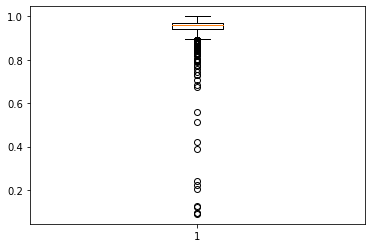

,score
count,2571.000000
mean,0.948744
std,0.057286
min,0.090000
25%,0.940000
50%,0.960000
75%,0.970000
max,1.000000


In [50]:
# Get accuracy of individual annotators

annotator_accuracy = labels_error_mask.sum(axis=0) / annotator_mask.sum(axis=0)
plt.boxplot(annotator_accuracy)
plt.show()

df_describe = pd.DataFrame(annotator_accuracy, columns=['score'])
df_describe.describe()

### Load models and data

In [61]:
# dictionaries to map to display name
method_adjust_pred_probs_display_dict = {
    "self_confidence-False": "Self Confidence",
    "self_confidence-True": "Adjusted Self Confidence",
    "normalized_margin-False": "Normalized Margin",
    "normalized_margin-True": "Adjusted Normalized Margin",
    "confidence_weighted_entropy-False": "Confidence Weighted Entropy",
    "entropy-False": "Entropy",
    "least_confidence-False": "Least Confidence",
}

model_display_name_dict = {"resnet18": "ResNet-18",}

models = ["resnet18"] # can also be: "resnet50d", "efficientnet_b1", "twins_pcpvt_base", "swin_base_patch4_window7_224"

# args to pass to get_label_quality_scores()
score_params = \
[
    ("self_confidence", False),
    ("self_confidence", True),
    ("normalized_margin", False),
    ("normalized_margin", True),
    ("confidence_weighted_entropy", False)
]

In [67]:
# read numpy files from model_train_pred
numpy_out_folder = './data/model_data/'
pred_probs = np.load(numpy_out_folder + "test_pred_probs.npy")
pred_labels = np.load(numpy_out_folder + "test_preds.npy")
true_labels = np.load(numpy_out_folder + "test_labels.npy")
images = np.load(numpy_out_folder + "test_images.npy", allow_pickle=True)


# boolean mask of label errors
labels = pred_labels # labels can change to annotator labels
label_errors_target = labels != true_labels

In [68]:
%%time
results = []

for score_param in score_params:
    method, adjust_pred_probs = score_param
    # compute scores
    label_quality_scores = get_label_quality_scores(labels=labels, pred_probs=pred_probs, method=method, adjust_pred_probs=adjust_pred_probs)
    # compute accuracy of detecting label errors
    auroc = roc_auc_score(label_errors_target, 1 - label_quality_scores)
    # compute Lift@K evaluation metric
    lift_at_k_dict = {}
    for k in range(1000, 11000, 1000):
        lift_at_k_dict[f"lift_at_{k}"] = lift_at_k(label_errors_target, 1 - label_quality_scores, k=k)
    # save results
    results = {
        "dataset": "cifar10",
        "model": "resnet18",
        "noise_config": "Noise Amount: 0.2 | Sparsity: 0.4",
        "method": method,
        "adjust_pred_probs": adjust_pred_probs,
        "auroc": auroc
    }
    # add the lift at k metrics
    results.update(lift_at_k_dict)
    # save results
    results_list.append(results)

CPU times: user 510 ms, sys: 2.84 ms, total: 513 ms
Wall time: 513 ms


In [69]:
# Create dataframe and export to csv
df_result = pd.DataFrame(results_list)
# ts = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# df.to_csv(f"label_quality_scores_evaluation_{ts}.csv", index=False)
df_result.to_csv(f"./data/benchmark_results/label_quality_scores_evaluation.csv", index=False)
df_result

,dataset,model,noise_config,method,adjust_pred_probs,auroc,lift_at_1000,lift_at_2000,lift_at_3000,lift_at_4000,lift_at_5000,lift_at_6000,lift_at_7000,lift_at_8000,lift_at_9000,lift_at_10000
0,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,self_confidence,False,0.772458,2.470792,2.131112,1.836146,1.671354,1.591519,1.523150,1.397045,1.239723,1.108707,1.0
1,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,self_confidence,True,0.697582,2.488100,1.938555,1.768354,1.584812,1.427953,1.302466,1.227051,1.133167,1.045243,1.0
2,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,normalized_margin,False,0.808249,2.462138,2.213328,2.084235,1.888793,1.730852,1.572191,1.400754,1.239182,1.109669,1.0
3,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,normalized_margin,True,0.799355,2.431848,2.187365,2.072696,1.928819,1.722198,1.530362,1.359337,1.220251,1.096687,1.0
4,cifar10,resnet18,Noise Amount: 0.2 | Sparsity: 0.4,confidence_weighted_entropy,False,0.747521,2.470792,2.102986,1.778451,1.598875,1.453051,1.427953,1.379737,1.239182,1.108226,1.0
